# Predicción de Threat Level en Tiroteos Fatales por Policía

## Objetivo
Predecir el nivel de amenaza (threat_level) usando modelos de Machine Learning basados en características demográficas y contextuales del incidente.

### Variable Objetivo
- **threat_level**: attack, other, undetermined

In [1]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métricas y evaluación
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            precision_score, recall_score, f1_score, roc_auc_score)

# Configuración
warnings.filterwarnings('ignore')
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 1. Carga de Datos

In [2]:
# Cargar el dataset
df = pd.read_csv('fatal-police-shootings-data.csv')

# Información básica del dataset
print("=" * 60)
print("INFORMACIÓN BÁSICA DEL DATASET")
print("=" * 60)
print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas\n")
print(f"Columnas: {list(df.columns)}\n")
print("Primeras 5 filas:")
print(df.head())

INFORMACIÓN BÁSICA DEL DATASET
Dimensiones: 5416 filas x 14 columnas

Columnas: ['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera']

Primeras 5 filas:
   id                name        date   manner_of_death       armed   age  \
0   3          Tim Elliot  2015-01-02              shot         gun  53.0   
1   4    Lewis Lee Lembke  2015-01-02              shot         gun  47.0   
2   5  John Paul Quintero  2015-01-03  shot and Tasered     unarmed  23.0   
3   8     Matthew Hoffman  2015-01-04              shot  toy weapon  32.0   
4   9   Michael Rodriguez  2015-01-04              shot    nail gun  39.0   

  gender race           city state  signs_of_mental_illness threat_level  \
0      M    A        Shelton    WA                     True       attack   
1      M    W          Aloha    OR                    False       attack   
2      M    H        Wichita    KS                 

## 2. Análisis Exploratorio de Datos (EDA)

In [3]:
# Información sobre tipos de datos y valores faltantes
print("=" * 60)
print("INFORMACIÓN DE DATOS Y VALORES FALTANTES")
print("=" * 60)
print(df.info())
print("\n" + "=" * 60)
print("VALORES FALTANTES POR COLUMNA")
print("=" * 60)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Faltantes': missing_values,
    'Porcentaje': missing_percent
})
missing_df = missing_df[missing_df['Valores Faltantes'] > 0].sort_values('Valores Faltantes', ascending=False)
print(missing_df)

INFORMACIÓN DE DATOS Y VALORES FALTANTES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5416 entries, 0 to 5415
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5416 non-null   int64  
 1   name                     5416 non-null   object 
 2   date                     5416 non-null   object 
 3   manner_of_death          5416 non-null   object 
 4   armed                    5189 non-null   object 
 5   age                      5181 non-null   float64
 6   gender                   5414 non-null   object 
 7   race                     4895 non-null   object 
 8   city                     5416 non-null   object 
 9   state                    5416 non-null   object 
 10  signs_of_mental_illness  5416 non-null   bool   
 11  threat_level             5416 non-null   object 
 12  flee                     5167 non-null   object 
 13  body_camera              5416 non-nul

In [4]:
# Estadísticas descriptivas de variables numéricas
print("=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 60)
print(df.describe())

ESTADÍSTICAS DESCRIPTIVAS
                id          age
count  5416.000000  5181.000000
mean   3010.398264    37.117931
std    1695.786456    13.116135
min       3.000000     6.000000
25%    1545.750000    27.000000
50%    3009.500000    35.000000
75%    4486.250000    46.000000
max    5927.000000    91.000000


DISTRIBUCIÓN DE LA VARIABLE OBJETIVO: threat_level

Conteo:
threat_level
attack          3495
other           1682
undetermined     239
Name: count, dtype: int64

Porcentaje:
threat_level
attack          64.531019
other           31.056130
undetermined     4.412851
Name: proportion, dtype: float64


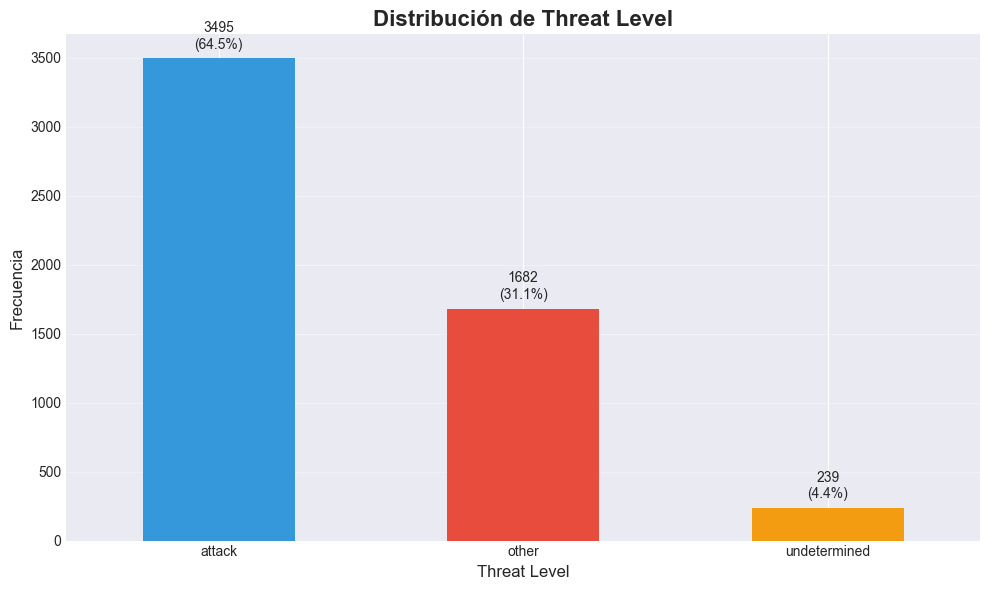

In [5]:
# Análisis de la variable objetivo: threat_level
print("=" * 60)
print("DISTRIBUCIÓN DE LA VARIABLE OBJETIVO: threat_level")
print("=" * 60)
threat_dist = df['threat_level'].value_counts()
threat_percent = df['threat_level'].value_counts(normalize=True) * 100

print("\nConteo:")
print(threat_dist)
print("\nPorcentaje:")
print(threat_percent)

# Visualización
plt.figure(figsize=(10, 6))
ax = threat_dist.plot(kind='bar', color=['#3498db', '#e74c3c', '#f39c12'])
plt.title('Distribución de Threat Level', fontsize=16, fontweight='bold')
plt.xlabel('Threat Level', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Agregar porcentajes en las barras
for i, (count, pct) in enumerate(zip(threat_dist.values, threat_percent.values)):
    ax.text(i, count + 50, f'{count}\n({pct:.1f}%)', 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

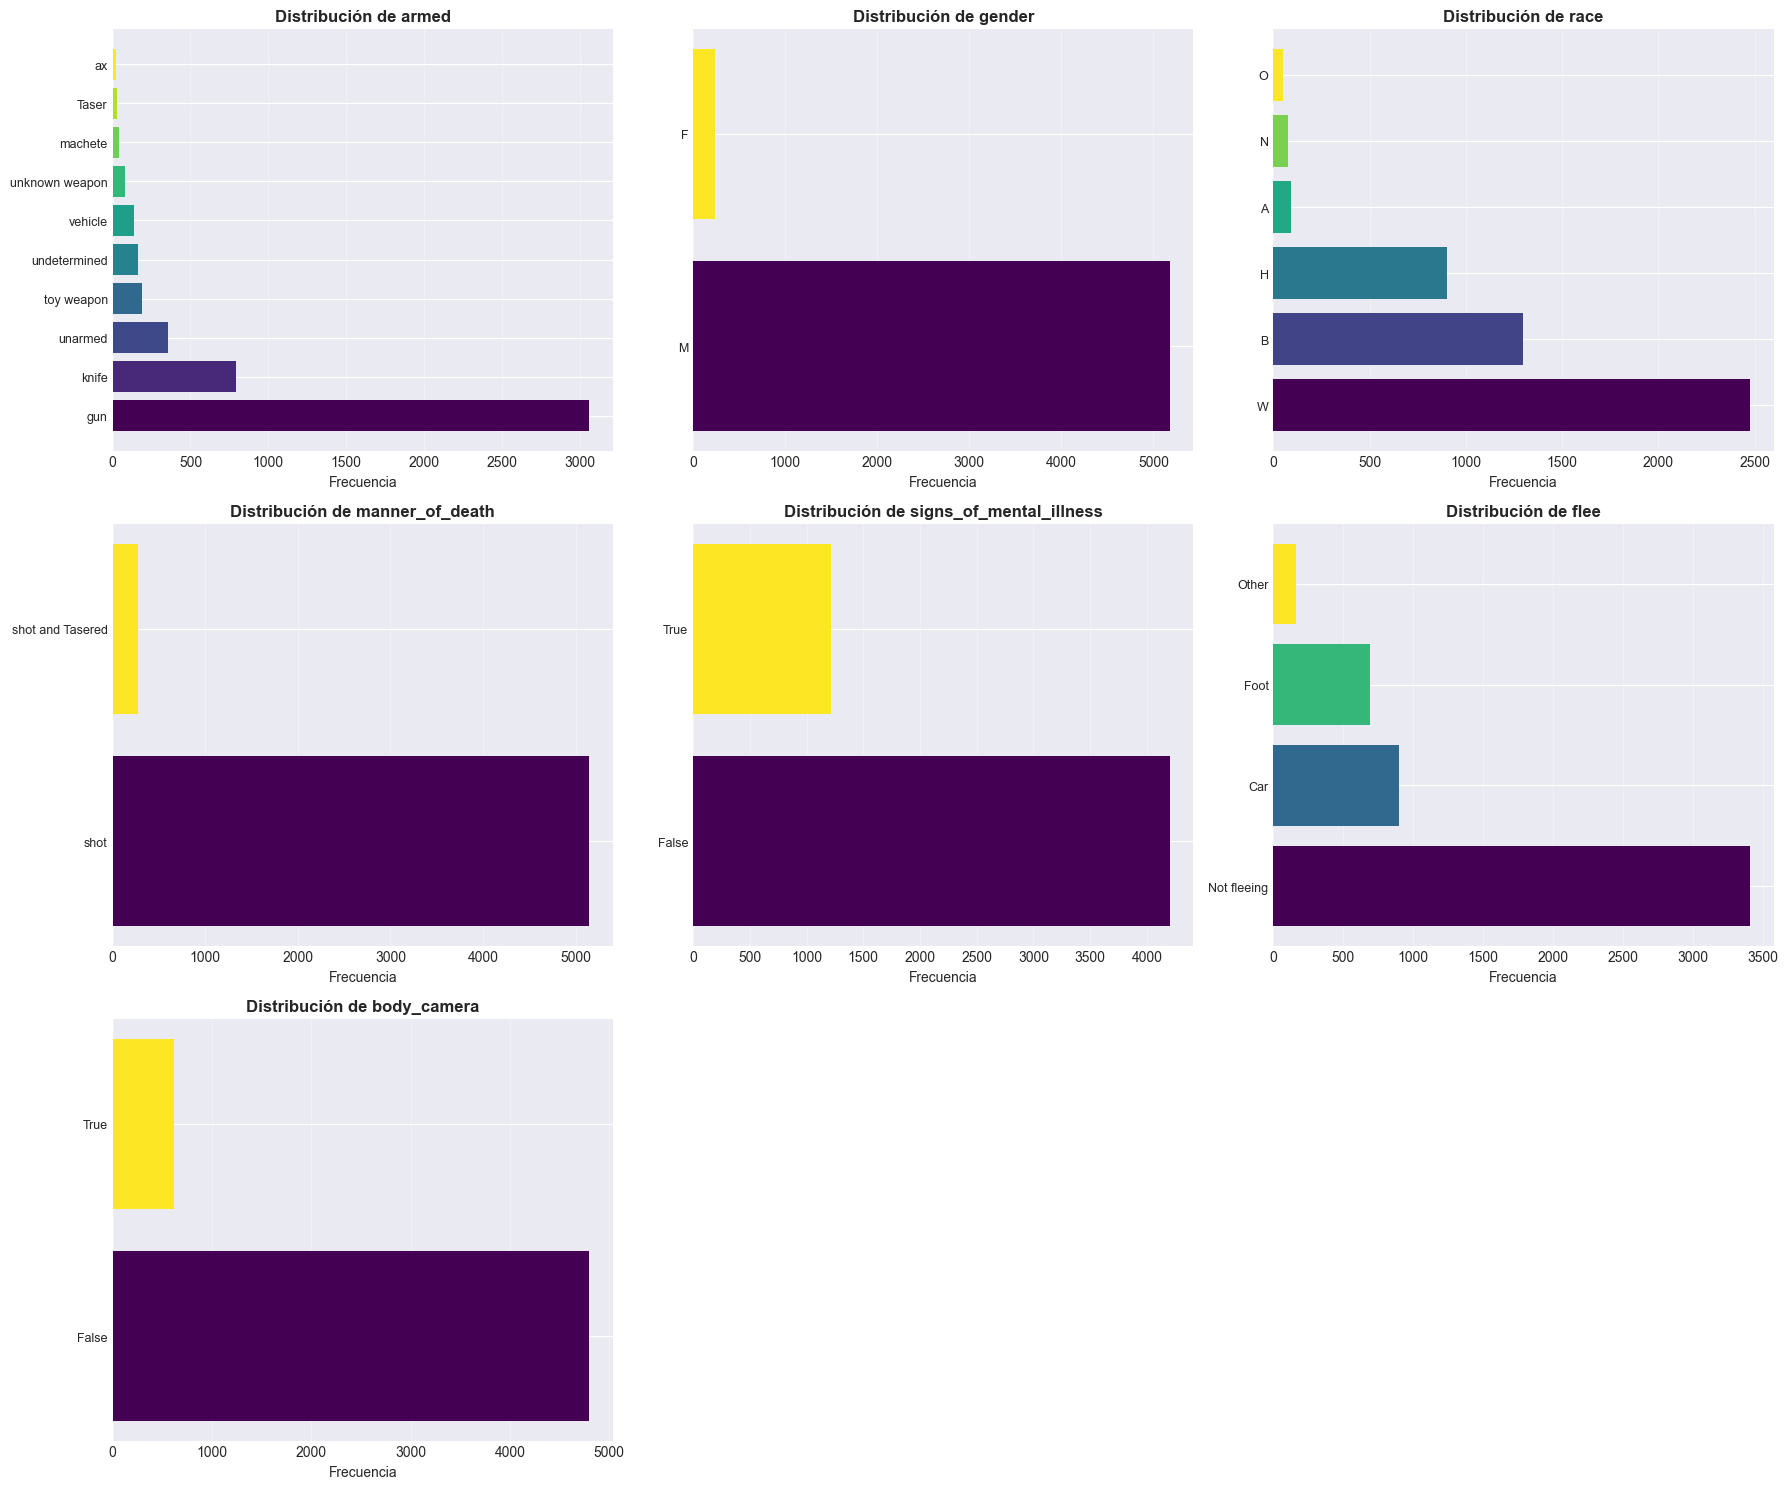

In [6]:
# Análisis de variables categóricas importantes
categorical_vars = ['armed', 'gender', 'race', 'manner_of_death', 'signs_of_mental_illness', 
                    'flee', 'body_camera']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for i, var in enumerate(categorical_vars):
    if i < len(axes):
        value_counts = df[var].value_counts().head(10)
        axes[i].barh(range(len(value_counts)), value_counts.values, color=plt.cm.viridis(np.linspace(0, 1, len(value_counts))))
        axes[i].set_yticks(range(len(value_counts)))
        axes[i].set_yticklabels(value_counts.index, fontsize=9)
        axes[i].set_xlabel('Frecuencia', fontsize=10)
        axes[i].set_title(f'Distribución de {var}', fontsize=12, fontweight='bold')
        axes[i].grid(axis='x', alpha=0.3)

# Ocultar ejes extra
for i in range(len(categorical_vars), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

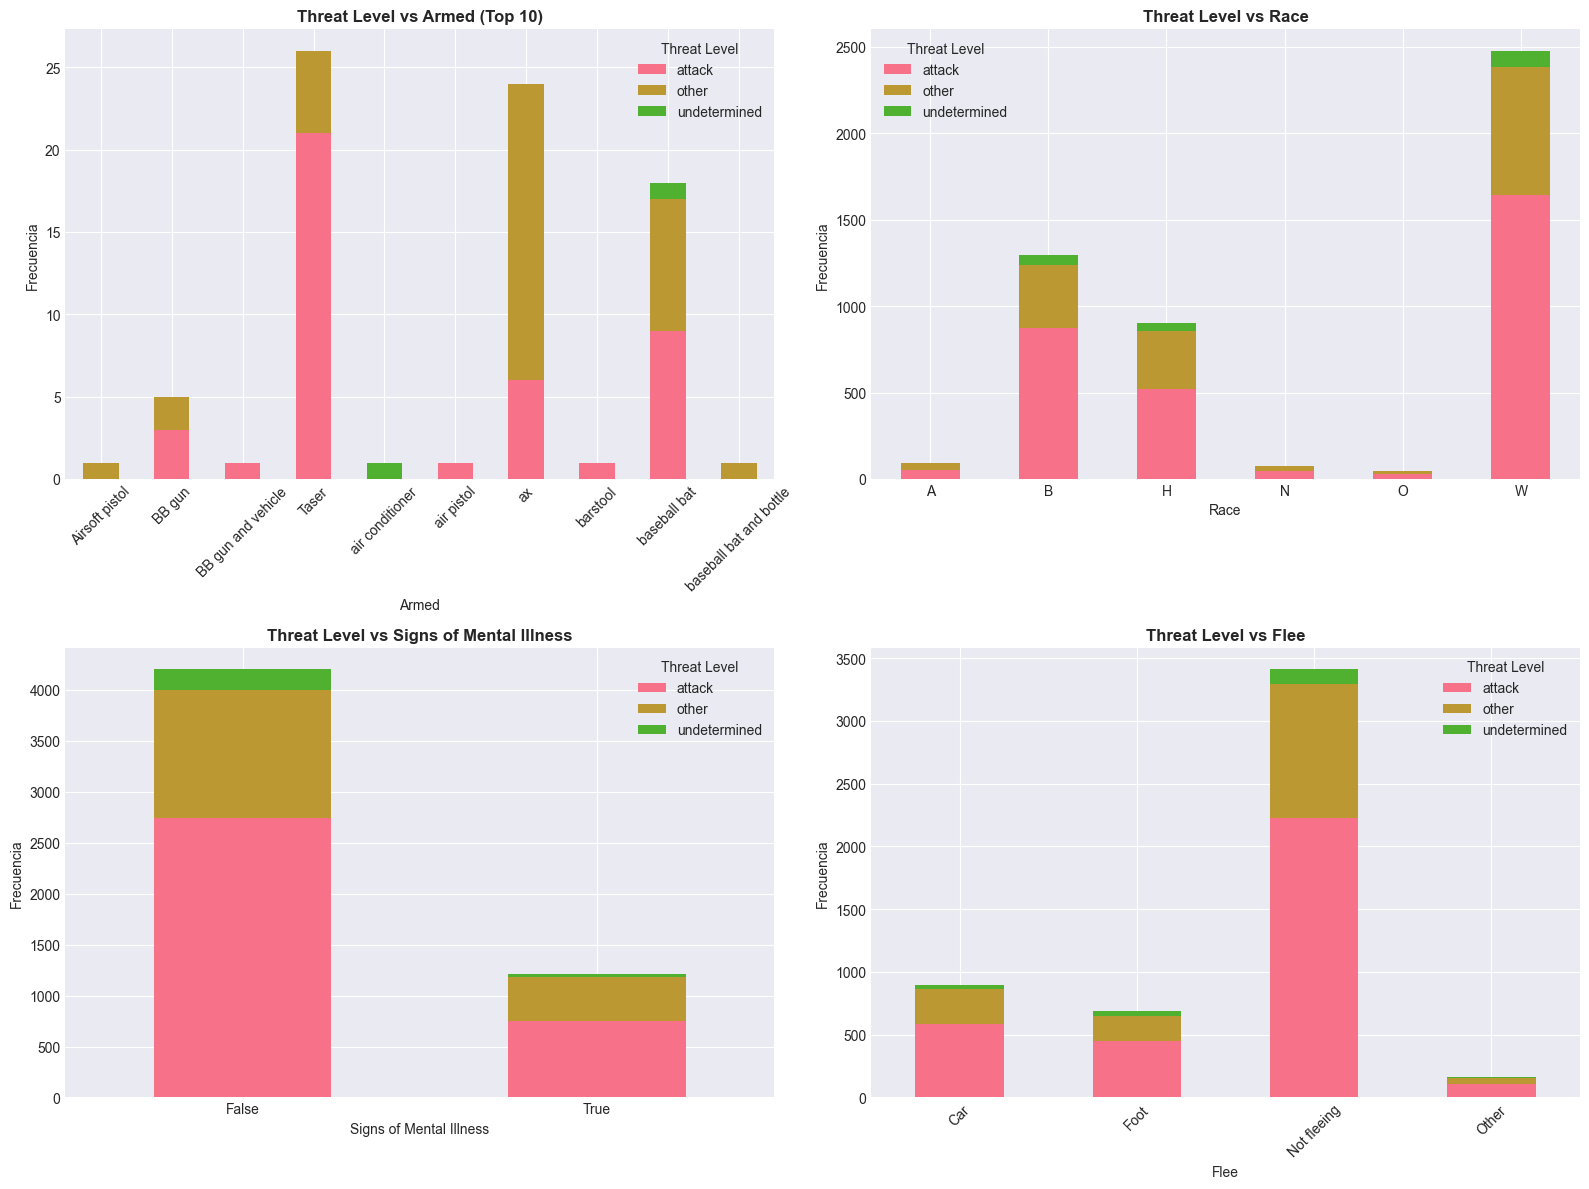

In [7]:
# Relación entre threat_level y otras variables categóricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Threat Level vs Armed
pd.crosstab(df['armed'], df['threat_level']).head(10).plot(kind='bar', ax=axes[0,0], stacked=True)
axes[0,0].set_title('Threat Level vs Armed (Top 10)', fontweight='bold')
axes[0,0].set_xlabel('Armed')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].legend(title='Threat Level')
axes[0,0].tick_params(axis='x', rotation=45)

# Threat Level vs Race
pd.crosstab(df['race'], df['threat_level']).plot(kind='bar', ax=axes[0,1], stacked=True)
axes[0,1].set_title('Threat Level vs Race', fontweight='bold')
axes[0,1].set_xlabel('Race')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].legend(title='Threat Level')
axes[0,1].tick_params(axis='x', rotation=0)

# Threat Level vs Signs of Mental Illness
pd.crosstab(df['signs_of_mental_illness'], df['threat_level']).plot(kind='bar', ax=axes[1,0], stacked=True)
axes[1,0].set_title('Threat Level vs Signs of Mental Illness', fontweight='bold')
axes[1,0].set_xlabel('Signs of Mental Illness')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].legend(title='Threat Level')
axes[1,0].tick_params(axis='x', rotation=0)

# Threat Level vs Flee
pd.crosstab(df['flee'], df['threat_level']).plot(kind='bar', ax=axes[1,1], stacked=True)
axes[1,1].set_title('Threat Level vs Flee', fontweight='bold')
axes[1,1].set_xlabel('Flee')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].legend(title='Threat Level')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

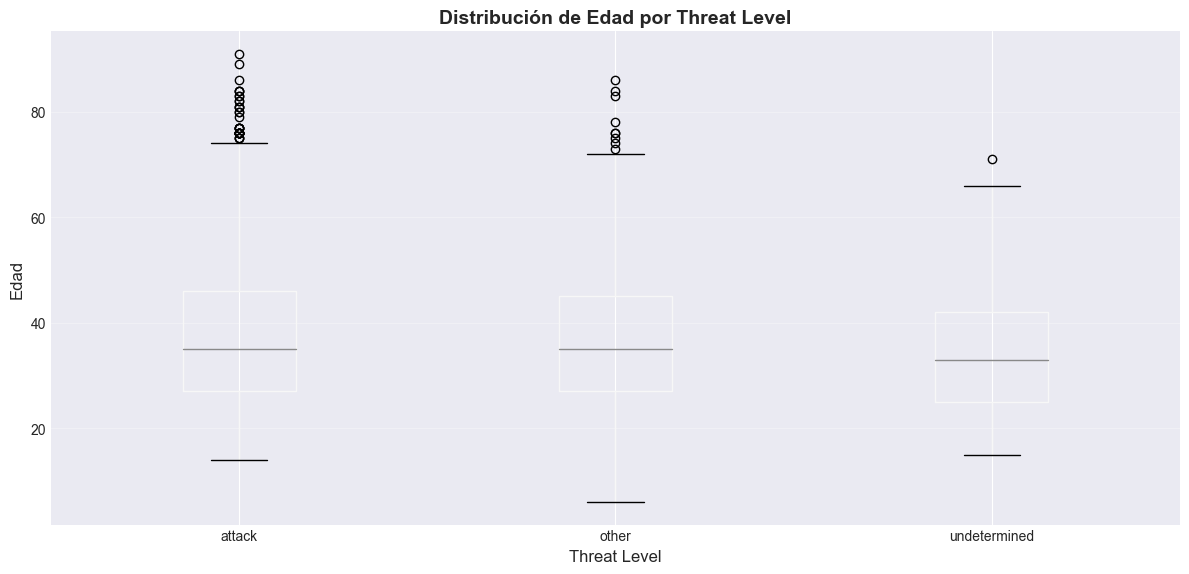


ESTADÍSTICAS DE EDAD POR THREAT LEVEL
               count       mean        std   min   25%   50%   75%   max
threat_level                                                            
attack        3357.0  37.607685  13.387040  14.0  27.0  35.0  46.0  91.0
other         1601.0  36.432854  12.582802   6.0  27.0  35.0  45.0  86.0
undetermined   223.0  34.663677  12.278630  15.0  25.0  33.0  42.0  71.0


In [8]:
# Distribución de edad por threat_level
plt.figure(figsize=(12, 6))
df_clean_age = df[df['age'].notna()]
df_clean_age.boxplot(column='age', by='threat_level', ax=plt.gca())
plt.title('Distribución de Edad por Threat Level', fontsize=14, fontweight='bold')
plt.suptitle('')  # Eliminar título automático
plt.xlabel('Threat Level', fontsize=12)
plt.ylabel('Edad', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas de edad por threat_level
print("\n" + "=" * 60)
print("ESTADÍSTICAS DE EDAD POR THREAT LEVEL")
print("=" * 60)
print(df_clean_age.groupby('threat_level')['age'].describe())

<Figure size 1400x600 with 0 Axes>

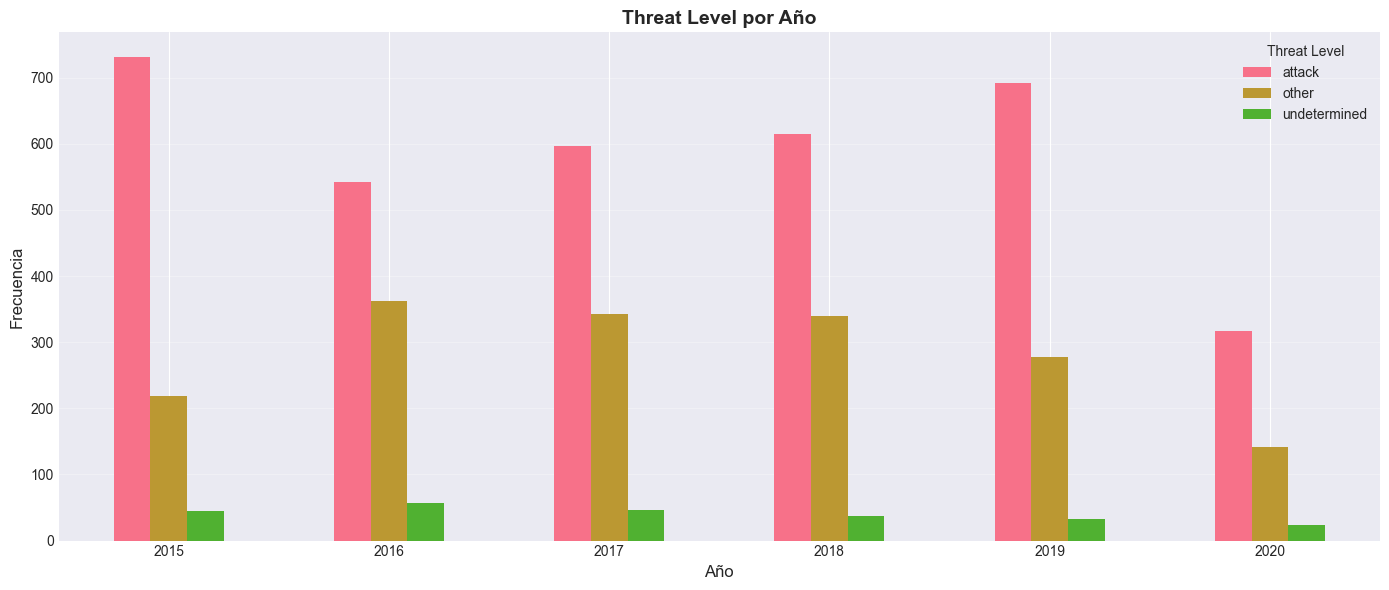

In [9]:
# Análisis temporal
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek

# Threat Level por año
plt.figure(figsize=(14, 6))
threat_by_year = pd.crosstab(df['year'], df['threat_level'])
threat_by_year.plot(kind='bar', stacked=False, figsize=(14, 6))
plt.title('Threat Level por Año', fontsize=14, fontweight='bold')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend(title='Threat Level')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Preprocesamiento de Datos

In [10]:
# Crear una copia del dataset para trabajar
df_processed = df.copy()

# Separar variable objetivo
y = df_processed['threat_level'].copy()

# Eliminar columnas que no serán usadas como features
# (id, name, date - ya extrajimos año, mes, día)
columns_to_drop = ['id', 'name', 'date', 'threat_level']
X = df_processed.drop(columns=columns_to_drop, errors='ignore')

print("Variables independientes (features):")
print(list(X.columns))
print(f"\nForma de X: {X.shape}")
print(f"Forma de y: {y.shape}")
print(f"\nValores únicos en y: {y.unique()}")

Variables independientes (features):
['manner_of_death', 'armed', 'age', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 'flee', 'body_camera', 'year', 'month', 'day_of_week']

Forma de X: (5416, 13)
Forma de y: (5416,)

Valores únicos en y: ['attack' 'other' 'undetermined']


In [11]:
# Identificar tipos de columnas
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Variables numéricas:")
print(numeric_features)
print("\nVariables categóricas:")
print(categorical_features)

# Verificar valores faltantes antes de procesamiento
print("\n" + "=" * 60)
print("VALORES FALTANTES EN FEATURES")
print("=" * 60)
missing_X = X.isnull().sum()
print(missing_X[missing_X > 0])

Variables numéricas:
['age', 'year', 'month', 'day_of_week']

Variables categóricas:
['manner_of_death', 'armed', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 'flee', 'body_camera']

VALORES FALTANTES EN FEATURES
armed     227
age       235
gender      2
race      521
flee      249
dtype: int64


In [12]:
# Manejo de valores faltantes
# Para variables categóricas: reemplazar con 'Unknown'
# Para variables numéricas: reemplazar con la mediana

# Copiar para no modificar el original
X_clean = X.copy()

# Valores faltantes en categóricas
for col in categorical_features:
    if X_clean[col].isnull().sum() > 0:
        if col == 'armed':
            X_clean[col].fillna('unknown', inplace=True)
        elif col == 'race':
            X_clean[col].fillna('Unknown', inplace=True)
        else:
            X_clean[col].fillna('Unknown', inplace=True)

# Valores faltantes en numéricas (age)
if 'age' in numeric_features:
    X_clean['age'].fillna(X_clean['age'].median(), inplace=True)

# Verificar que no quedan valores faltantes
print("Valores faltantes después del preprocesamiento:")
print(X_clean.isnull().sum().sum())
print("\nVerificación por columna:")
missing_after = X_clean.isnull().sum()
print(missing_after[missing_after > 0] if missing_after.sum() > 0 else "No hay valores faltantes")

Valores faltantes después del preprocesamiento:
0

Verificación por columna:
No hay valores faltantes


In [13]:
# Convertir variables booleanas a numéricas
bool_columns = ['signs_of_mental_illness', 'body_camera']
for col in bool_columns:
    if col in X_clean.columns:
        X_clean[col] = X_clean[col].astype(int)

# Actualizar listas de features
numeric_features = X_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_clean.select_dtypes(include=['object']).columns.tolist()

print("Variables numéricas después de conversión:")
print(numeric_features)
print("\nVariables categóricas:")
print(categorical_features)

Variables numéricas después de conversión:
['age', 'signs_of_mental_illness', 'body_camera', 'year', 'month', 'day_of_week']

Variables categóricas:
['manner_of_death', 'armed', 'gender', 'race', 'city', 'state', 'flee']


## 4. Feature Engineering

In [14]:
# Agrupar categorías raras en 'armed'
armed_counts = X_clean['armed'].value_counts()
# Mantener las top 10 categorías más frecuentes, el resto agrupar como 'other'
top_armed = armed_counts.head(10).index.tolist()
X_clean['armed_grouped'] = X_clean['armed'].apply(lambda x: x if x in top_armed else 'other')

# Eliminar la columna original 'armed' y usar la agrupada
X_clean = X_clean.drop(columns=['armed'])
categorical_features.remove('armed')
categorical_features.append('armed_grouped')

print(f"Categorías únicas en 'armed_grouped': {X_clean['armed_grouped'].nunique()}")
print(f"\nDistribución:")
print(X_clean['armed_grouped'].value_counts())

Categorías únicas en 'armed_grouped': 11

Distribución:
armed_grouped
gun               3060
knife              792
unarmed            353
other              347
unknown            227
toy weapon         186
undetermined       164
vehicle            139
unknown weapon      79
machete             43
Taser               26
Name: count, dtype: int64


In [15]:
# Crear pipeline de preprocesamiento con ColumnTransformer
# Esto aplicará diferentes transformaciones a diferentes tipos de columnas

# Imputadores (aunque ya manejamos los valores faltantes, los incluimos por seguridad)
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

# Transformadores
numeric_transformer = StandardScaler()  # Estandarización para variables numéricas
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Crear preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("Preprocessor creado exitosamente")
print(f"Features numéricas a transformar: {len(numeric_features)}")
print(f"Features categóricas a transformar: {len(categorical_features)}")

Preprocessor creado exitosamente
Features numéricas a transformar: 6
Features categóricas a transformar: 7


In [16]:
# Aplicar transformaciones
X_transformed = preprocessor.fit_transform(X_clean)

# Crear nombres de features después de OneHotEncoding
numeric_feature_names = numeric_features.copy()
categorical_feature_names = []

# Obtener nombres de features categóricas después de OneHotEncoding
cat_transformer = preprocessor.named_transformers_['cat']
if hasattr(cat_transformer, 'get_feature_names_out'):
    categorical_feature_names = list(cat_transformer.get_feature_names_out(categorical_features))
else:
    # Fallback para versiones antiguas
    categorical_feature_names = [f'{col}_{val}' for col in categorical_features 
                                 for val in X_clean[col].unique()[:10]]  # Aproximación

feature_names = numeric_feature_names + categorical_feature_names

print(f"Forma de X después de transformación: {X_transformed.shape}")
print(f"Número de features originales: {X_clean.shape[1]}")
print(f"Número de features después de transformación: {X_transformed.shape[1]}")

Forma de X después de transformación: (5416, 2548)
Número de features originales: 13
Número de features después de transformación: 2548


## 5. División de Datos (Train/Test Split)

In [17]:
# Codificar variable objetivo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Crear diccionario de mapeo
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapeo de clases de threat_level:")
for label, encoded in sorted(label_mapping.items(), key=lambda x: x[1]):
    print(f"  {label}: {encoded}")

# Dividir datos en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print("\n" + "=" * 60)
print("DIVISIÓN DE DATOS")
print("=" * 60)
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X_transformed)*100:.1f}%)")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X_transformed)*100:.1f}%)")
print(f"\nDistribución de clases en entrenamiento:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    label = label_encoder.inverse_transform([u])[0]
    print(f"  {label} ({u}): {c} muestras ({c/len(y_train)*100:.1f}%)")
print(f"\nDistribución de clases en prueba:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    label = label_encoder.inverse_transform([u])[0]
    print(f"  {label} ({u}): {c} muestras ({c/len(y_test)*100:.1f}%)")

Mapeo de clases de threat_level:
  attack: 0
  other: 1
  undetermined: 2

DIVISIÓN DE DATOS
Conjunto de entrenamiento: 4332 muestras (80.0%)
Conjunto de prueba: 1084 muestras (20.0%)

Distribución de clases en entrenamiento:
  attack (0): 2796 muestras (64.5%)
  other (1): 1345 muestras (31.0%)
  undetermined (2): 191 muestras (4.4%)

Distribución de clases en prueba:
  attack (0): 699 muestras (64.5%)
  other (1): 337 muestras (31.1%)
  undetermined (2): 48 muestras (4.4%)


## 6. Entrenamiento de Modelos

### 6.1 Random Forest Classifier (Modelo Principal)

In [18]:
# Crear modelo base de Random Forest
rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Manejar desbalance de clases
)

print("Entrenando modelo Random Forest base...")
rf_base.fit(X_train, y_train)

# Predicciones
y_pred_rf_base = rf_base.predict(X_test)

# Métricas base
print("\n" + "=" * 60)
print("RESULTADOS RANDOM FOREST BASE")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_base):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf_base, 
                          target_names=label_encoder.classes_))

Entrenando modelo Random Forest base...

RESULTADOS RANDOM FOREST BASE
Accuracy: 0.6863

Classification Report:
              precision    recall  f1-score   support

      attack       0.73      0.86      0.79       699
       other       0.56      0.40      0.47       337
undetermined       0.59      0.21      0.31        48

    accuracy                           0.69      1084
   macro avg       0.62      0.49      0.52      1084
weighted avg       0.67      0.69      0.67      1084



In [19]:
# Optimización de hiperparámetros con GridSearchCV
print("Optimizando hiperparámetros de Random Forest...")
print("Esto puede tomar varios minutos...")

# Grid de hiperparámetros a probar
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

# Modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GridSearchCV
grid_search_rf = GridSearchCV(
    rf, 
    param_grid_rf, 
    cv=5, 
    scoring='f1_macro',  # F1 macro para clases desbalanceadas
    n_jobs=-1,
    verbose=1
)

# Entrenar
grid_search_rf.fit(X_train, y_train)

print("\n" + "=" * 60)
print("MEJORES HIPERPARÁMETROS RANDOM FOREST")
print("=" * 60)
print(grid_search_rf.best_params_)
print(f"\nMejor score en CV: {grid_search_rf.best_score_:.4f}")

# Mejor modelo
rf_best = grid_search_rf.best_estimator_

Optimizando hiperparámetros de Random Forest...
Esto puede tomar varios minutos...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

MEJORES HIPERPARÁMETROS RANDOM FOREST
{'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Mejor score en CV: 0.6014


In [20]:
# Predicciones con el mejor modelo
y_pred_rf = rf_best.predict(X_test)
y_pred_proba_rf = rf_best.predict_proba(X_test)

print("=" * 60)
print("RESULTADOS RANDOM FOREST OPTIMIZADO")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_rf, average='macro'):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

RESULTADOS RANDOM FOREST OPTIMIZADO
Accuracy: 0.6836
Precision (macro): 0.5940
Recall (macro): 0.5707
F1-score (macro): 0.5797

Classification Report:
              precision    recall  f1-score   support

      attack       0.79      0.75      0.77       699
       other       0.52      0.58      0.55       337
undetermined       0.47      0.38      0.42        48

    accuracy                           0.68      1084
   macro avg       0.59      0.57      0.58      1084
weighted avg       0.69      0.68      0.69      1084



### 6.2 XGBoost Classifier (Modelo Alternativo)

In [21]:
# Crear modelo XGBoost
print("Entrenando modelo XGBoost...")

xgb_base = XGBClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    use_label_encoder=False
)

xgb_base.fit(X_train, y_train)

# Predicciones
y_pred_xgb_base = xgb_base.predict(X_test)

print("\n" + "=" * 60)
print("RESULTADOS XGBOOST BASE")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_base):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_base, target_names=label_encoder.classes_))

Entrenando modelo XGBoost...

RESULTADOS XGBOOST BASE
Accuracy: 0.6762

Classification Report:
              precision    recall  f1-score   support

      attack       0.75      0.82      0.78       699
       other       0.51      0.44      0.47       337
undetermined       0.44      0.25      0.32        48

    accuracy                           0.68      1084
   macro avg       0.57      0.50      0.52      1084
weighted avg       0.66      0.68      0.66      1084



In [22]:
# Optimización básica de XGBoost
print("\nOptimizando hiperparámetros de XGBoost...")
print("Esto puede tomar varios minutos...")

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss', use_label_encoder=False)

grid_search_xgb = GridSearchCV(
    xgb,
    param_grid_xgb,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train, y_train)

print("\n" + "=" * 60)
print("MEJORES HIPERPARÁMETROS XGBOOST")
print("=" * 60)
print(grid_search_xgb.best_params_)
print(f"\nMejor score en CV: {grid_search_xgb.best_score_:.4f}")

xgb_best = grid_search_xgb.best_estimator_


Optimizando hiperparámetros de XGBoost...
Esto puede tomar varios minutos...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

MEJORES HIPERPARÁMETROS XGBOOST
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Mejor score en CV: 0.6041


In [23]:
# Predicciones con el mejor modelo XGBoost
y_pred_xgb = xgb_best.predict(X_test)
y_pred_proba_xgb = xgb_best.predict_proba(X_test)

print("=" * 60)
print("RESULTADOS XGBOOST OPTIMIZADO")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred_xgb, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred_xgb, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred_xgb, average='macro'):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

RESULTADOS XGBOOST OPTIMIZADO
Accuracy: 0.6854
Precision (macro): 0.6024
Recall (macro): 0.5642
F1-score (macro): 0.5786

Classification Report:
              precision    recall  f1-score   support

      attack       0.78      0.76      0.77       699
       other       0.52      0.58      0.55       337
undetermined       0.50      0.35      0.41        48

    accuracy                           0.69      1084
   macro avg       0.60      0.56      0.58      1084
weighted avg       0.69      0.69      0.69      1084



## 7. Evaluación y Comparación de Modelos

COMPARACIÓN DE MODELOS
       Modelo  Accuracy  Precision (macro)  Recall (macro)  F1-Score (macro)
Random Forest  0.683579           0.594026        0.570691          0.579672
      XGBoost  0.685424           0.602377        0.564153          0.578577


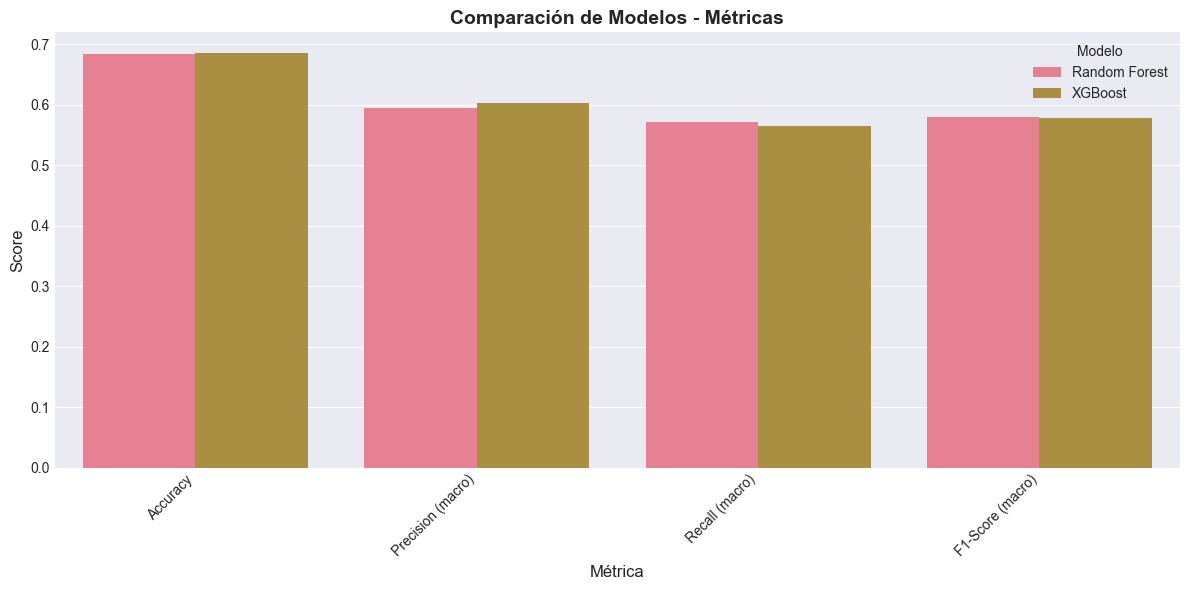

In [24]:
# Comparación de modelos
comparison_df = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precision (macro)': [
        precision_score(y_test, y_pred_rf, average='macro'),
        precision_score(y_test, y_pred_xgb, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_test, y_pred_rf, average='macro'),
        recall_score(y_test, y_pred_xgb, average='macro')
    ],
    'F1-Score (macro)': [
        f1_score(y_test, y_pred_rf, average='macro'),
        f1_score(y_test, y_pred_xgb, average='macro')
    ]
})

print("=" * 60)
print("COMPARACIÓN DE MODELOS")
print("=" * 60)
print(comparison_df.to_string(index=False))

# Visualización de comparación
fig, ax = plt.subplots(figsize=(12, 6))
comparison_df_melted = comparison_df.melt(id_vars='Modelo', var_name='Métrica', value_name='Score')
sns.barplot(data=comparison_df_melted, x='Métrica', y='Score', hue='Modelo', ax=ax)
ax.set_title('Comparación de Modelos - Métricas', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Métrica', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Modelo')
plt.tight_layout()
plt.show()

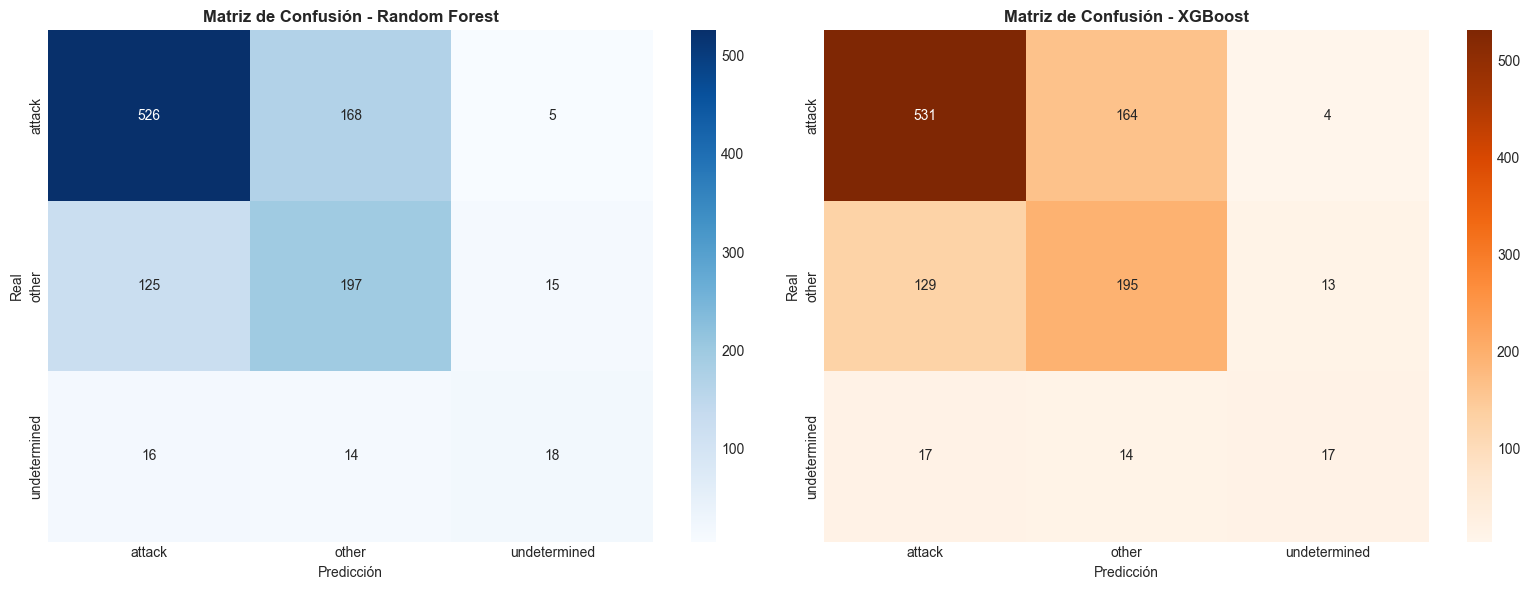

In [25]:
# Matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
axes[0].set_title('Matriz de Confusión - Random Forest', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicción', fontsize=10)
axes[0].set_ylabel('Real', fontsize=10)

# XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
axes[1].set_title('Matriz de Confusión - XGBoost', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicción', fontsize=10)
axes[1].set_ylabel('Real', fontsize=10)

plt.tight_layout()
plt.show()

## 8. Análisis de Importancia de Características

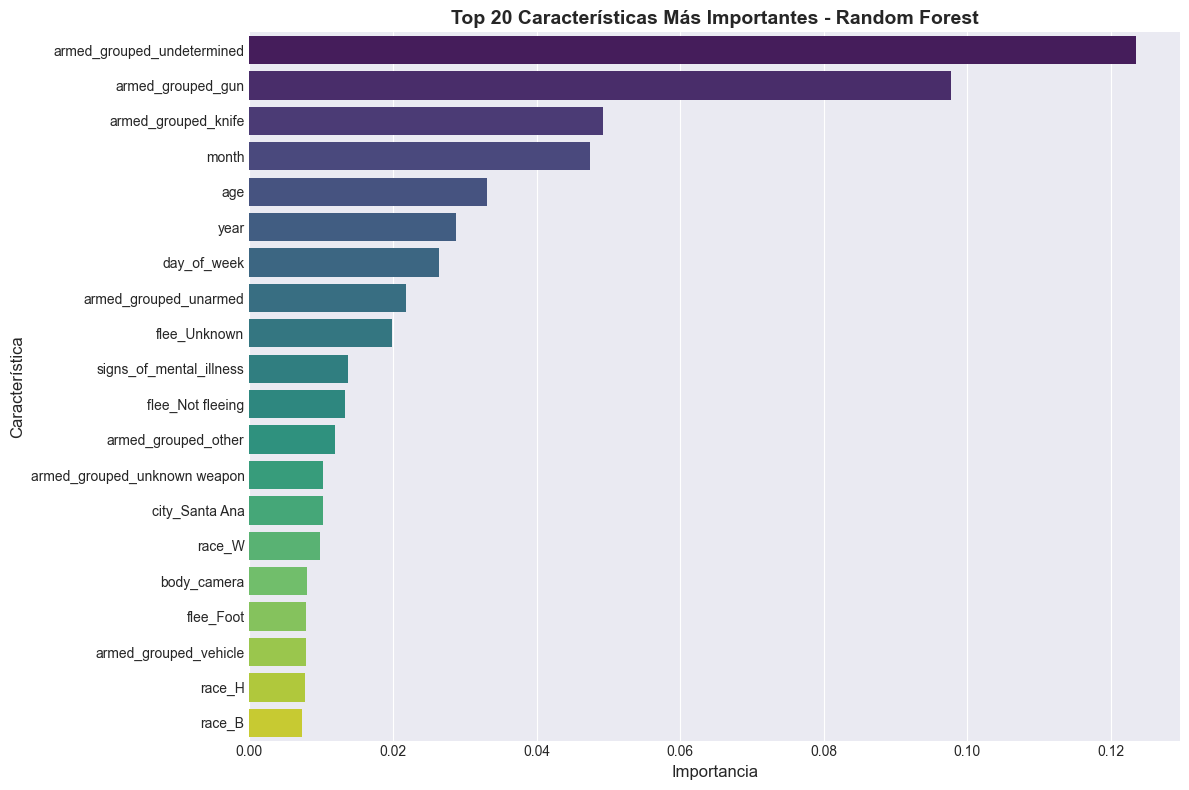

Top 20 características más importantes (Random Forest):
                     feature  importance
  armed_grouped_undetermined    0.123445
           armed_grouped_gun    0.097749
         armed_grouped_knife    0.049277
                       month    0.047374
                         age    0.033158
                        year    0.028829
                 day_of_week    0.026442
       armed_grouped_unarmed    0.021780
                flee_Unknown    0.019832
     signs_of_mental_illness    0.013751
            flee_Not fleeing    0.013351
         armed_grouped_other    0.011960
armed_grouped_unknown weapon    0.010235
              city_Santa Ana    0.010185
                      race_W    0.009808
                 body_camera    0.008031
                   flee_Foot    0.007899
       armed_grouped_vehicle    0.007885
                      race_H    0.007760
                      race_B    0.007311


In [26]:
# Importancia de características - Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': feature_names[:len(rf_best.feature_importances_)],
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_rf, y='feature', x='importance', palette='viridis')
plt.title('Top 20 Características Más Importantes - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.tight_layout()
plt.show()

print("Top 20 características más importantes (Random Forest):")
print(feature_importance_rf.to_string(index=False))

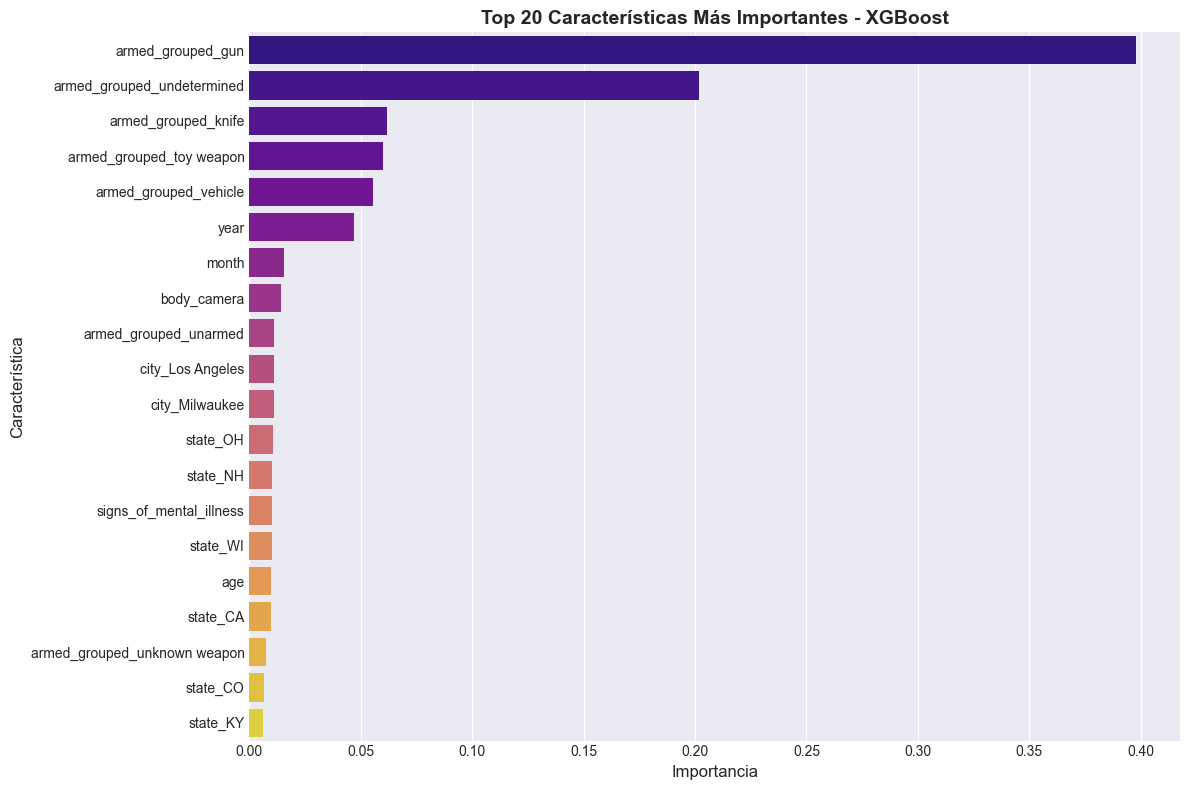

Top 20 características más importantes (XGBoost):
                     feature  importance
           armed_grouped_gun    0.397778
  armed_grouped_undetermined    0.201756
         armed_grouped_knife    0.061865
    armed_grouped_toy weapon    0.060118
       armed_grouped_vehicle    0.055653
                        year    0.046809
                       month    0.015474
                 body_camera    0.014395
       armed_grouped_unarmed    0.011220
            city_Los Angeles    0.011198
              city_Milwaukee    0.011060
                    state_OH    0.010496
                    state_NH    0.010086
     signs_of_mental_illness    0.010064
                    state_WI    0.009944
                         age    0.009661
                    state_CA    0.009526
armed_grouped_unknown weapon    0.007509
                    state_CO    0.006408
                    state_KY    0.006311


In [27]:
# Importancia de características - XGBoost
feature_importance_xgb = pd.DataFrame({
    'feature': feature_names[:len(xgb_best.feature_importances_)],
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_xgb, y='feature', x='importance', palette='plasma')
plt.title('Top 20 Características Más Importantes - XGBoost', fontsize=14, fontweight='bold')
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.tight_layout()
plt.show()

print("Top 20 características más importantes (XGBoost):")
print(feature_importance_xgb.to_string(index=False))

## 9. Conclusiones y Resumen

### Resumen del Análisis:

1. **Preprocesamiento**: Se manejaron valores faltantes y se codificaron variables categóricas
2. **Feature Engineering**: Se crearon características temporales y se agruparon categorías raras
3. **Modelos Evaluados**: Random Forest y XGBoost, ambos optimizados con GridSearchCV
4. **Mejor Modelo**: Comparar resultados según las métricas obtenidas

### Recomendaciones:

- El modelo que tenga mejor F1-Score (macro) es el más equilibrado para clases desbalanceadas
- Considerar las características más importantes para entender los factores clave
- El modelo puede mejorarse con más datos o ajustes adicionales de hiperparámetros